### Read train (historical_data.csv) and test (predict_data.csv) data from files

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,cross_val_score,KFold,cross_val_predict,cross_validate
from sklearn.linear_model import Ridge,Lasso, ElasticNet,SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.neural_network import MLPRegressor


Cursory look at data. How many null cells? 
Best case scenario, delete rows with null. But if too many consider imputing values

In [150]:
# Get train dataset
delivery_df = pd.read_csv('./historical_data.csv')
print(f'Total number of data-points: ', len(delivery_df))
print('Number of null cells in each column: \n',delivery_df.isnull().sum())

Total number of data-points:  197428
Number of null cells in each column: 
 market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64


In [151]:
# Get prediction dataset

predict_df = pd.read_csv('./predict_data.csv')
print(f'Total number of data-points: ', len(predict_df))
print('Number of null cells in each column: \n',predict_df.isnull().sum())

Total number of data-points:  54778
Number of null cells in each column: 
 market_id                                        250
created_at                                         0
store_id                                           0
store_primary_category                          1343
order_protocol                                   283
total_items                                        0
subtotal                                           0
num_distinct_items                                 0
min_item_price                                     0
max_item_price                                     0
total_onshift_dashers                           4633
total_busy_dashers                              4633
total_outstanding_orders                        4633
estimated_order_place_duration                     0
estimated_store_to_consumer_driving_duration      11
delivery_id                                        0
platform                                           0
dtype: int64


Impute missing values in train and test sets



In [152]:
#  Logically, there is a correlation between market_id and store_id 

from collections import defaultdict
store_market_dic = {}

def impute_market_id(row, store_id=None):
    # impute marketID from those rows that have its corresponding storeID along with marketID in other rows  
    if not pd.isnull(row['market_id']):
        return row
    if store_id in store_market_dic:
        row['market_id'] = store_market_dic[store_id]
        return row
    else:
        val_c = delivery_df[delivery_df['store_id'] == store_id]['market_id'].value_counts()
        if val_c.any():
            store_market_dic[store_id] = val_c.idxmax()
        else:
            store_market_dic[store_id] = np.nan
        row['market_id'] = store_market_dic[store_id]
        return row


delivery_df = delivery_df.apply(lambda row: impute_market_id(row, row['store_id']), axis = 1)


In [153]:
# impute values in validation set

store_market_dic ={}

predict_df = predict_df.apply(lambda row: impute_market_id(row, row['store_id']), axis = 1)
predict_df['market_id'] = predict_df['market_id'].fillna(value=predict_df['market_id'].value_counts().idxmax())

In [154]:
#  store ID and store category are related as restaurants have fixed specific cuisines. 

store_category_dic={}
def impute_store_primary_category(row, store_id=None):
    # impute category based on store ID  
    if not pd.isnull(row['store_primary_category']):
        return row
    if store_id in store_category_dic:
        row['store_primary_category'] = store_category_dic[store_id]
        return row
    else:
        val_c = delivery_df[delivery_df['store_id'] == store_id]['store_primary_category'].value_counts()
        if val_c.any():
            store_category_dic[store_id] = val_c.idxmax()
        else:
            store_category_dic[store_id] = 'other'
        row['store_primary_category'] = store_category_dic[store_id]
        return row

delivery_df=delivery_df.apply(lambda row: impute_store_primary_category(row, row['store_id']), axis = 1)


In [155]:
store_category_dic={}
predict_df = predict_df.apply(lambda row: impute_store_primary_category(row, row['store_id']), axis = 1)

In [156]:
# most frequent value imputed for order_protocol column
delivery_df['order_protocol'] = delivery_df['order_protocol'].fillna(value=delivery_df['order_protocol'].value_counts().idxmax())
predict_df['order_protocol'] = predict_df['order_protocol'].fillna(value=predict_df['order_protocol'].value_counts().idxmax())

In [157]:
# impute other values in the prediction dataset

predict_df['total_onshift_dashers'] = predict_df['total_onshift_dashers'].fillna(value=predict_df['total_onshift_dashers'].median())
predict_df['total_busy_dashers'] = predict_df['total_busy_dashers'].fillna(value=predict_df['total_busy_dashers'].median())
predict_df['total_outstanding_orders'] = predict_df['total_outstanding_orders'].fillna(value=predict_df['total_outstanding_orders'].median())
predict_df['estimated_store_to_consumer_driving_duration'] = predict_df['estimated_store_to_consumer_driving_duration'].fillna(value=predict_df['estimated_store_to_consumer_driving_duration'].median())

predict_df.isnull().sum()

market_id                                       0
created_at                                      0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
delivery_id                                     0
platform                                        0
dtype: int64

In [158]:
# drop unused columns in test set
 
predict_df.drop(['created_at','platform'], axis=1, inplace=True)
predict_df

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_id
0,3.0,5477,mexican,1.0,5,7500,4,800,1800,4.0,4.0,4.0,446,670.0,194096
1,3.0,5477,mexican,1.0,5,7100,4,800,1500,4.0,1.0,1.0,446,446.0,236895
2,4.0,5477,thai,1.0,4,4500,2,750,1500,9.0,7.0,6.0,446,504.0,190868
3,3.0,5477,mexican,1.0,1,1700,1,1400,1400,3.0,3.0,3.0,446,687.0,183076
4,1.0,2841,italian,1.0,2,3150,2,1525,1625,4.0,4.0,4.0,446,528.0,186200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54773,1.0,2956,fast,4.0,1,1088,1,709,709,13.0,11.0,11.0,251,824.0,174203
54774,1.0,2956,fast,4.0,4,1824,2,345,405,26.0,26.0,32.0,251,477.0,138333
54775,1.0,2956,fast,4.0,5,2933,5,345,825,10.0,10.0,12.0,251,318.0,34110
54776,1.0,2956,fast,4.0,2,1438,2,649,739,12.0,12.0,18.0,251,593.0,178028


Generate Target values:  total duration of delivery = time of creation  - time of delivery

In [159]:
# create target values in train set for prediction

created_time=pd.to_datetime(delivery_df['created_at'])
deliver_time=pd.to_datetime(delivery_df['actual_delivery_time'])
delivery_df['Target'] = (deliver_time - created_time).dt.total_seconds()

Plot heatmap and correlation plots to get a feel of the dataset

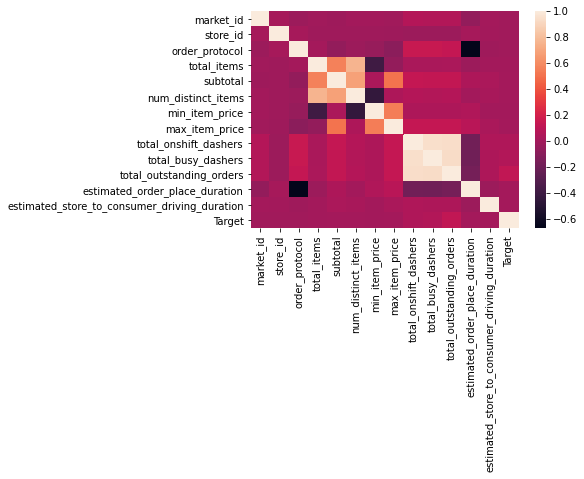

In [160]:
import seaborn as sns
sns.heatmap(delivery_df.corr())

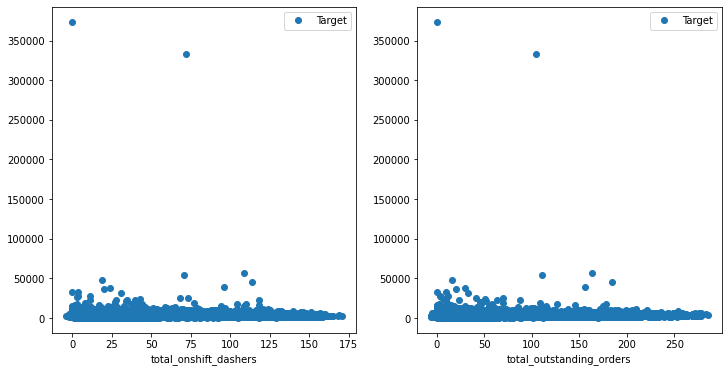

In [161]:
figure, axes = plt.subplots(1, 2, figsize=(12,6))
delivery_df.plot(ax=axes[0],x='total_onshift_dashers', y='Target', style='o')
delivery_df.plot(ax=axes[1],x='total_outstanding_orders', y='Target', style='o')

Clean data to suit machine learning models. \\
Some negative and extreme values are removed. \\
This could be well attributed to the noise added to de-identify data but avoid any kind of misinterpretation, these values are discard

mean 2908.25737383561
2690      8516859.0
185550     373879.0
27189      332482.0
83055       57032.0
190860      54447.0
Name: Target, dtype: float64
83055     57032.0
190860    54447.0
86952     48178.0
76743     45685.0
105825    39352.0
Name: Target, dtype: float64
mean 2861.5823227871824


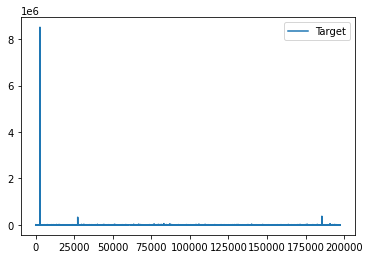

In [162]:
# check for outliers and remove them

print('mean',delivery_df['Target'].mean())
delivery_df.plot(use_index=True,y='Target')

# remove outliers

print(delivery_df['Target'].nlargest(5))

#  3 abnormally high values for delivery time. Evaluates to 3-4 days. Safe to ignore
for _ in range(3):
  delivery_df = delivery_df.drop(delivery_df['Target'].idxmax())


print(delivery_df['Target'].nlargest(5))
print('mean',delivery_df['Target'].mean())


In [163]:
# check for any duplicates 

dups = delivery_df.duplicated()

print(dups.any())
# list duplicate rows
# print(delivery_nonnull_df[dups])

False


In [164]:
# How can total_busy_dashers be negative? Could be due to noise added to deidentify data. But removing them to be on safe side

print(len(delivery_df[delivery_df['total_busy_dashers']<0]))
delivery_df = delivery_df[delivery_df['total_busy_dashers']>=0]

21


unique [ 33.   1.   6.   2.  10.   7.   8.   3.  16.   5.   4.  24.  12.  19.
  21.  22.  27.  13.  18. 117. 130. 121.  94.  34.  17.  38.  20.  15.
  39.  26.  30.  35.  11.  14.  32.  29.  25.  23.  61.  41.  58.  51.
  57.  60.   9. 108.  72.  89. 112.  55. 126.  80.  69. 125. 113. 105.
  98.  86.  90.  87.  74.  84.  91.  96. 123. 101. 119. 129.  66.  81.
  36.  75.  43.  70.  65.  77. 114.  62. 116. 102.  76.  67.  64.  88.
  73.  63.  46.  28.  47. 110.  97.  42.  79.  49.  50.  37.  92. 103.
  44.  68.  56.   0. 107.  78.  71. 128. 104.  45.  31. 100.  40.  53.
 115. 109.  99.  85.  59. 118.  54.  52.  48. 132. 127. 133. 131. 149.
  93. 111.  95.  82. 136. 120. 134. 124. 106. 137.  83. 152. 147. 144.
 150. 145. 122. 155. 135. 151. 140. 141. 143. 138. 139. 156. 146.  -2.
 160. 158. 154. 153. 148. 142. 157. 171.  -1.  -3. 162. 165. 163. 164.
 159. 169.  -4. 168.]
largest 21545     171.0
170897    169.0
190274    168.0
100018    165.0
140992    164.0
Name: total_onshift_dashers, dt

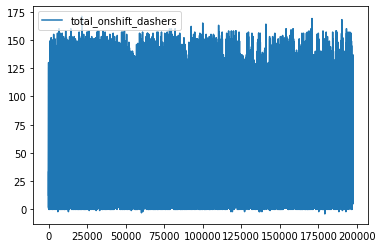

In [165]:

delivery_df.plot(use_index=True,y='total_onshift_dashers')  

print('unique',delivery_df['total_onshift_dashers'].unique())

print('largest',delivery_df['total_onshift_dashers'].nlargest(5))
print('smallest',delivery_df['total_onshift_dashers'].nsmallest(5))

In [166]:
# remove rows with values that are negative. Total number of dashers cannot be negative

print(len(delivery_df[delivery_df['total_onshift_dashers']<0]))
delivery_df = delivery_df[delivery_df['total_onshift_dashers']>=0]

20


unique [ 21.   2.   0.   9.   7.  18.   1.   4.   3.   8.  12.  26.  11.  30.
  16.  39.  24.  27.  20.  13. 178. 230. 205. 149.  28.  15.  42.  43.
  33.   5.  37.  46.  36.  14.  29.  32.  72.  41.  54.  49.  23.  56.
  60.  10.   6. 154. 144.  34. 100. 173.  80. 202. 124. 130. 181. 188.
 148. 150. 127. 160. 107. 123. 159. 186. 143. 190. 171. 261. 132.  67.
 120. 158.  59.  38.  47.  68.  92.  99. 175. 102. 184. 121.  17.  96.
 111.  22. 131. 141.  89.  48.  65. 194.  73.  45. 203. 134. 126. 183.
  64. 167.  31. 153. 119.  75.  95.  52. 118. 191.  61. 106.  19.  58.
 152. 101.  35. 151.  83. 179.  97.  44.  25. 147. 169. 135. 142. 165.
 172.  91.  40. 237. 198. 220. 219.  78.  90. 138. 168.  85.  81. 212.
 192. 137. 189.  51.  74.  62.  63.  50. 122.  93.  66. 207. 113. 114.
  69.  57.  86.  71.  79.  87.  88.  70.  84. 108.  76.  53.  55.  82.
 110.  98. 185. 225. 104. 145. 247. 232.  77. 133. 103. 174. 164. 193.
 208. 231. 163.  94. 146. 115. 129. 112. 136. 162. 176. 246. 199. 116.

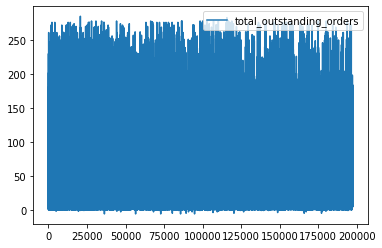

In [167]:
delivery_df.plot(use_index=True,y='total_outstanding_orders')  

print('unique',delivery_df['total_outstanding_orders'].unique())

print('largest',delivery_df['total_outstanding_orders'].nlargest(5))
print('smallest',delivery_df['total_outstanding_orders'].nsmallest(5))

In [168]:
# how can outstanding orders be negative? Data collection issue or noise added

print(len(delivery_df[delivery_df['total_outstanding_orders']<0]))
delivery_df = delivery_df[delivery_df['total_outstanding_orders']>=0]

40


unique [ 3441  1900  6900 ... 12145   348  9317]
largest 188378    26800
96456     22500
53072     20350
73129     19250
171276    18920
Name: subtotal, dtype: int64
smallest 1070    0
1837    0
3947    0
4240    0
7360    0
Name: subtotal, dtype: int64
---------------------
unique [  4   1   6   3   2   5   7   8  10   9  13  16  12  25  17  11  24  30
  14  31  35  40  26  28  21  20  15  19  18  23  29  34  42  22  56  36
  57  39  47  45  38  33  27  41 411  32  59  51  50  37  48  44  49  64
  66]
largest 47231     411
182800     66
182796     64
75577      59
15053      57
Name: total_items, dtype: int64
smallest 1     1
2     1
12    1
14    1
26    1
Name: total_items, dtype: int64
---------------------
unique [ 4  1  5  3  2  6  7 10  8 14  9 11 12 13 15 20 18 16 17 19]
10515     20
138629    19
10519     18
30382     18
60260     18
Name: num_distinct_items, dtype: int64
smallest 1     1
2     1
12    1
14    1
26    1
Name: num_distinct_items, dtype: int64
------------------

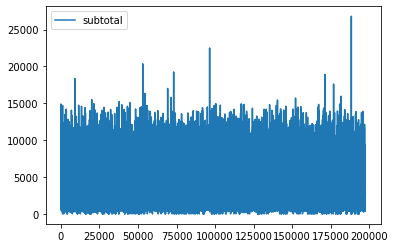

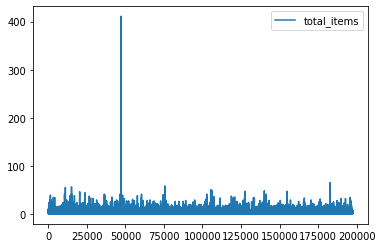

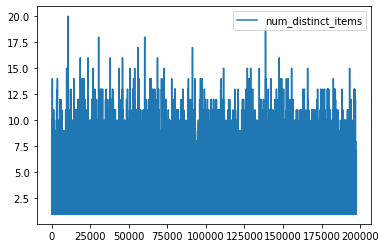

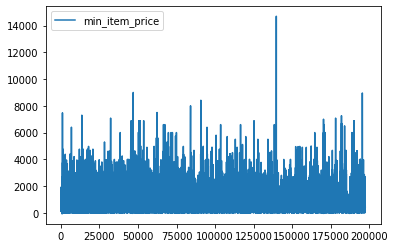

In [169]:

delivery_df.plot(use_index=True,y='subtotal')  

print('unique',delivery_df['subtotal'].unique())

print('largest',delivery_df['subtotal'].nlargest(5))
print('smallest',delivery_df['subtotal'].nsmallest(5))


print('---------------------')


delivery_df.plot(use_index=True,y='total_items')  

print('unique',delivery_df['total_items'].unique())

print('largest',delivery_df['total_items'].nlargest(5))
print('smallest',delivery_df['total_items'].nsmallest(5))


print('---------------------')

delivery_df.plot(use_index=True,y='num_distinct_items')  

print('unique',delivery_df['num_distinct_items'].unique())

print(delivery_df['num_distinct_items'].nlargest(5))
print('smallest',delivery_df['num_distinct_items'].nsmallest(5))


print('---------------------')

delivery_df.plot(use_index=True,y='min_item_price')  

print('unique',delivery_df['min_item_price'].unique())

print('largest',delivery_df['min_item_price'].nlargest(5))
print('smallest',delivery_df['min_item_price'].nsmallest(5))

print('---------------------')

In [170]:
# How can minimum price be negative? Discount? Peculiar. Can account for reduced price but negative price is odd. Some loss here or noise addition is causing this

len(delivery_df[delivery_df['min_item_price']<0])
delivery_df[delivery_df['min_item_price']<0]
delivery_df=delivery_df[delivery_df['min_item_price']>=0]

unique [1239 1400 1900 ... 3879 2868  448]
largest 139718    14700
46914      8999
195513     8959
16862      8500
90756      8415
Name: max_item_price, dtype: int64
smallest 20220    0
20222    0
20225    0
20227    0
20228    0
Name: max_item_price, dtype: int64


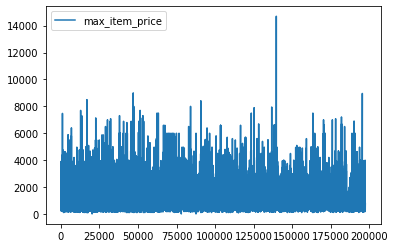

In [171]:
delivery_df.plot(use_index=True,y='max_item_price')  

print('unique',delivery_df['max_item_price'].unique())

print('largest',delivery_df['max_item_price'].nlargest(5))
print('smallest',delivery_df['max_item_price'].nsmallest(5))

In [172]:
# Subtotal is greater than 0 but max item price is 0. Is noise addition resulting in such odd behaviour? 

anolmy = delivery_df.query('max_item_price == 0 & subtotal >0')
delivery_df = pd.concat([delivery_df,anolmy]).drop_duplicates(keep=False)


 

---



In [173]:
# Check the value types and counts in each column

print(delivery_df['market_id'].value_counts())
print(delivery_df['store_id'].value_counts())
print(delivery_df['store_primary_category'].value_counts())
print(delivery_df['order_protocol'].value_counts())

2.0    55067
4.0    47625
1.0    37978
3.0    21750
5.0    17987
6.0      655
Name: market_id, dtype: int64
6865    937
1311    862
314     815
1686    764
3937    721
       ... 
5220      1
3694      1
1956      1
5926      1
8         1
Name: store_id, Length: 5789, dtype: int64
american             18568
pizza                16182
mexican              15935
burger               10248
sandwich              9197
                     ...  
african                 10
lebanese                 9
belgian                  2
alcohol-plus-food        1
chocolate                1
Name: store_primary_category, Length: 73, dtype: int64
1.0    51441
3.0    48015
5.0    41981
2.0    21346
4.0    17581
6.0      681
7.0       19
Name: order_protocol, dtype: int64


In [174]:
#Drop rows whose values could not be imputed

delivery_df.dropna( axis=0, inplace = True)
delivery_df.isna().sum()

market_id                                       0
created_at                                      0
actual_delivery_time                            0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
Target                                          0
dtype: int64

In [175]:
predict_df.isna().sum()

market_id                                       0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
delivery_id                                     0
dtype: int64

Mean delivery duration is : 2861 seconds. This is used to develop the average baseline model


In [176]:
m = np.array(delivery_df['Target']).mean()
l = delivery_df['Target'].shape
true_v = np.array(delivery_df['Target'])

mean_pred = np.full(l,m) 
                  
print('RMSE: ',np.sqrt(mean_squared_error(true_v, mean_pred)))
print('MAE: ',mean_absolute_error(true_v, mean_pred))
print('R2 score: ',r2_score(true_v, mean_pred))

RMSE:  1164.2230842383783
MAE:  824.0279705653321
R2 score:  0.0


Convert a few datatypes to facilitate encoding

In [177]:
# convert datatypes 
print(delivery_df.dtypes)
print(predict_df.dtypes)

convert_dict = {'market_id': int, 
                'store_id': str,
                'order_protocol': int,
                'total_onshift_dashers': int,
                'total_busy_dashers':int,
                'total_outstanding_orders':int
               } 
  
delivery_df = delivery_df.astype(convert_dict) 
predict_df = predict_df.astype(convert_dict) 

market_id                                       float64
created_at                                       object
actual_delivery_time                             object
store_id                                          int64
store_primary_category                           object
order_protocol                                  float64
total_items                                       int64
subtotal                                          int64
num_distinct_items                                int64
min_item_price                                    int64
max_item_price                                    int64
total_onshift_dashers                           float64
total_busy_dashers                              float64
total_outstanding_orders                        float64
estimated_order_place_duration                    int64
estimated_store_to_consumer_driving_duration    float64
Target                                          float64
dtype: object
market_id                         

One can use a one-hot encoding up to thousands. Although inconvenient, the models can generally handle it.

Use one-hot encoding for those with fewer unique categories. Use feature Hashing technique to encode those with large number of unique categories.

In [178]:
# Combine train and test sets to generate one-hot encodings to avoid mismatch in size of columns generated

train_len=len(delivery_df.market_id)

combined_market_id = pd.concat([delivery_df.market_id, predict_df.market_id], axis = 0)
combined_store_id = pd.concat([delivery_df.store_id, predict_df.store_id], axis = 0)
combined_store_primary_category = pd.concat([delivery_df.store_primary_category, predict_df.store_primary_category], axis = 0)
combined_order_protocol = pd.concat([delivery_df.order_protocol, predict_df.order_protocol], axis = 0)


onehot_market_id = pd.get_dummies(combined_market_id, prefix='market_id')
onehot_store_id = pd.get_dummies(combined_store_id, prefix='store_id')
onehot_store_primary_category = pd.get_dummies(combined_store_primary_category, prefix='store_primary_category')
onehot_order_protocol = pd.get_dummies(combined_order_protocol, prefix='order_protocol')


train_market_id = onehot_market_id[:train_len]
valid_market_id = onehot_market_id[train_len:]

train_store_id =onehot_store_id[:train_len]
valid_store_id = onehot_store_id[train_len:]

train_store_primary_category = onehot_store_primary_category[:train_len]
valid_store_primary_category = onehot_store_primary_category[train_len:]

train_order_protocol =onehot_order_protocol[:train_len]
valid_order_protocol = onehot_order_protocol[train_len:]

print('verify lengths here')

verify lengths here


In [179]:
valid_nonnull_df_all = copy.copy(predict_df)

predict_df.drop(['market_id','store_id','store_primary_category','order_protocol'], axis=1, inplace=True)

In [180]:
delivery_nonnull_df_all = copy.copy(delivery_df)
delivery_df.drop(['market_id','created_at','actual_delivery_time','store_id','store_primary_category','order_protocol'], axis=1, inplace=True)


In [181]:
#Combine one-hot encoded and numeric features to generate all features vector

valid_one_hot = pd.concat([valid_market_id,valid_store_primary_category,valid_order_protocol ], axis=1)

valid_all_features_df = pd.concat([predict_df, valid_one_hot], axis = 1)

In [182]:
#Combine one-hot encoded and numeric features to generate all features vector

one_hot = pd.concat([train_market_id,train_store_primary_category,train_order_protocol ], axis=1)

all_features_df = pd.concat([delivery_df, one_hot], axis = 1).drop('Target', axis= 1)

In [183]:
all_features_df.isnull().sum(axis = 1)
# delivery_nonnull_df=delivery_df.dropna()

0         0
1         0
2         0
3         0
4         0
         ..
197423    0
197424    0
197425    0
197426    0
197427    0
Length: 180574, dtype: int64

In [184]:
# Save delivery_id for future use

delivery_id = valid_all_features_df['delivery_id']
valid_all_features_df.drop(['delivery_id'],axis=1,inplace=True)

In [185]:
# Since store_id has too many unique values for one-hot encoding, encoding with a hash value reduce the number of features. 
# market_id, store_id and store category are related. Hence using fewer number of features as much of the information is also encoded in the other two columns

from sklearn.feature_extraction import FeatureHasher

fh = FeatureHasher(n_features=5, input_type='string')
hashed_features = fh.fit_transform(delivery_nonnull_df_all['store_id'])
hashed_features = hashed_features.toarray()
print(hashed_features.shape)

all_features_temp = copy.copy(all_features_df)
hash_df = pd.DataFrame(hashed_features)

hash_df.reset_index(drop=True, inplace=True)
all_features_temp.reset_index(drop=True, inplace=True)
all_features_df = pd.concat([all_features_temp,hash_df], axis=1)


(180574, 5)


In [186]:

valid_hashed_storeid = fh.fit_transform(valid_nonnull_df_all['store_id'])
valid_hashed_storeid = valid_hashed_storeid.toarray()

valid_all_features_temp = copy.copy(valid_all_features_df)
valid_hash_df = pd.DataFrame(valid_hashed_storeid)

valid_hash_df.reset_index(drop=True, inplace=True)
valid_all_features_temp.reset_index(drop=True, inplace=True)
valid_all_features_df = pd.concat([valid_all_features_temp,valid_hash_df], axis=1)

Feature engineering to reduce dimensionality. Principal Component Analysis is performed to achieve this.

Standardization assumes that your observations fit a Gaussian distribution (bell curve) with a well behaved mean and standard deviation. You can still standardize your data if this expectation is not met, but you may not get reliable results.

In [187]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_scaler = StandardScaler()
pca_scaler.fit(all_features_df)
all_features_std = pca_scaler.transform(all_features_df)

pca = PCA(.95)
pca.fit(all_features_std)
pca.n_components_

eigen_features = pca.transform(all_features_std)

In [188]:
import numpy as np
n_pcs = pca.components_.shape[0]
print('n_pcs',pca.components_.shape)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = all_features_df.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
print(most_important_names)

n_pcs (86, 102)
['total_busy_dashers', 'num_distinct_items', 'max_item_price', 'order_protocol_3', 0, 'market_id_4', 'order_protocol_5', 'order_protocol_4', 'order_protocol_2', 1, 'market_id_1', 'market_id_3', 4, 3, 'order_protocol_6', 'store_primary_category_mexican', 'store_primary_category_other', 'store_primary_category_sandwich', 'store_primary_category_american', 'store_primary_category_burger', 'store_primary_category_thai', 'store_primary_category_sandwich', 'store_primary_category_vietnamese', 'store_primary_category_thai', 'store_primary_category_seafood', 'store_primary_category_mediterranean', 'market_id_6', 'market_id_6', 'store_primary_category_salad', 'store_primary_category_asian', 'store_primary_category_cafe', 'store_primary_category_korean', 'store_primary_category_barbecue', 'store_primary_category_alcohol', 'store_primary_category_middle-eastern', 'store_primary_category_sushi', 'store_primary_category_pasta', 'store_primary_category_dim-sum', 'store_primary_catego

In [189]:
# get df with only important features

all_imp_features_df = all_features_df[list(set(most_important_names))]
all_imp_features_df

,0,1,store_primary_category_french,3,4,store_primary_category_gastropub,store_primary_category_pakistani,order_protocol_4,store_primary_category_tapas,store_primary_category_moroccan,store_primary_category_german,store_primary_category_lebanese,order_protocol_3,store_primary_category_bubble-tea,store_primary_category_middle-eastern,store_primary_category_ethiopian,store_primary_category_alcohol,store_primary_category_turkish,num_distinct_items,store_primary_category_southern,store_primary_category_comfort-food,store_primary_category_burger,store_primary_category_seafood,store_primary_category_burmese,store_primary_category_belgian,store_primary_category_peruvian,market_id_4,order_protocol_2,store_primary_category_mediterranean,store_primary_category_latin-american,order_protocol_6,store_primary_category_barbecue,store_primary_category_filipino,store_primary_category_vegan,store_primary_category_dim-sum,store_primary_category_russian,store_primary_category_chocolate,order_protocol_5,store_primary_category_korean,store_primary_category_japanese,estimated_store_to_consumer_driving_duration,store_primary_category_asian,store_primary_category_salad,store_primary_category_mexican,store_primary_category_pasta,store_primary_category_vegetarian,store_primary_category_vietnamese,store_primary_category_thai,store_primary_category_brazilian,total_busy_dashers,store_primary_category_malaysian,market_id_3,store_primary_category_cafe,store_primary_category_spanish,store_primary_category_sandwich,store_primary_category_european,store_primary_category_singaporean,store_primary_category_other,store_primary_category_sushi,store_primary_category_persian,market_id_6,market_id_1,store_primary_category_irish,store_primary_category_african,store_primary_category_american,order_protocol_7,store_primary_category_steak,max_item_price,store_primary_category_alcohol-plus-food
0,1.0,0.0,0,-1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,861.0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1239,0
1,1.0,0.0,0,2.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,690.0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1400,0
2,1.0,0.0,0,2.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,690.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1900,0
3,1.0,0.0,0,2.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,289.0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1800,0
4,1.0,0.0,0,2.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,650.0,0,0,1,0,0,0,0,0,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1600,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180569,2.0,2.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,331.0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,649,0
180570,2.0,2.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,915.0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,825,0
180571,2.0,2.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,795.0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,399,0
180572,3.0,0.0,0,0.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,384.0,0,0,0,0,0,0,0,0,7,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,535,0


In [190]:
all_imp_valid_features_df = valid_all_features_df[list(set(most_important_names))]

all_imp_valid_features_df

,0,1,store_primary_category_french,3,4,store_primary_category_gastropub,store_primary_category_pakistani,order_protocol_4,store_primary_category_tapas,store_primary_category_moroccan,store_primary_category_german,store_primary_category_lebanese,order_protocol_3,store_primary_category_bubble-tea,store_primary_category_middle-eastern,store_primary_category_ethiopian,store_primary_category_alcohol,store_primary_category_turkish,num_distinct_items,store_primary_category_southern,store_primary_category_comfort-food,store_primary_category_burger,store_primary_category_seafood,store_primary_category_burmese,store_primary_category_belgian,store_primary_category_peruvian,market_id_4,order_protocol_2,store_primary_category_mediterranean,store_primary_category_latin-american,order_protocol_6,store_primary_category_barbecue,store_primary_category_filipino,store_primary_category_vegan,store_primary_category_dim-sum,store_primary_category_russian,store_primary_category_chocolate,order_protocol_5,store_primary_category_korean,store_primary_category_japanese,estimated_store_to_consumer_driving_duration,store_primary_category_asian,store_primary_category_salad,store_primary_category_mexican,store_primary_category_pasta,store_primary_category_vegetarian,store_primary_category_vietnamese,store_primary_category_thai,store_primary_category_brazilian,total_busy_dashers,store_primary_category_malaysian,market_id_3,store_primary_category_cafe,store_primary_category_spanish,store_primary_category_sandwich,store_primary_category_european,store_primary_category_singaporean,store_primary_category_other,store_primary_category_sushi,store_primary_category_persian,market_id_6,market_id_1,store_primary_category_irish,store_primary_category_african,store_primary_category_american,order_protocol_7,store_primary_category_steak,max_item_price,store_primary_category_alcohol-plus-food
0,1.0,0.0,0,2.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,670.0,0,0,1,0,0,0,0,0,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1800,0
1,1.0,0.0,0,2.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,446.0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1500,0
2,1.0,0.0,0,2.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,504.0,0,0,0,0,0,0,1,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1500,0
3,1.0,0.0,0,2.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,687.0,0,0,1,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1400,0
4,0.0,1.0,0,-1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,528.0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1625,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54773,2.0,2.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,824.0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,709,0
54774,2.0,2.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,477.0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,405,0
54775,2.0,2.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,318.0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,825,0
54776,2.0,2.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,593.0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,739,0


Generate train, test and prediction sets

In [191]:
no_of_test_samples = 1000
# for experimentation

# X = all_imp_features_df.iloc[0:-no_of_test_samples,:]
# y = delivery_nonnull_df_all['Target'].iloc[0:-no_of_test_samples]

# To generate final model, train will all data
X = all_imp_features_df
y = delivery_nonnull_df_all['Target']

X_test = all_imp_features_df.iloc[-no_of_test_samples:,:]
y_test = delivery_nonnull_df_all['Target'].iloc[-no_of_test_samples:]


# dataset to make final predictions on
X_valid = all_imp_valid_features_df
print(X.shape, y.shape, X_test.shape, y_test.shape, X_valid.shape)



(180574, 69) (180574,) (1000, 69) (1000,) (54778, 69)


In [192]:
# pipeline to scale numeric and one-hot differently. But general practise is to do it together

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

numerical_preprocess = Pipeline([
    ( 'std_scaler', MinMaxScaler() )
])
# example output
# print(numerical_preprocess.fit_transform(all_imp_features_df))

preprocess = ColumnTransformer([
        ( "numerical", numerical_preprocess, all_imp_features_df.columns)],
         remainder="passthrough")

# sample output
# preprocess.fit_transform(all_imp_features_df)

In [193]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=1)

Grid search scripts for ML models

In [194]:
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error

# # Linear Regression

linear_pipeline = Pipeline([
    ('Linear', LinearRegression())
])


linear_parameters = {'Linear__normalize':[True]}
grid_linear = GridSearchCV(linear_pipeline,
                          param_grid=linear_parameters,
                          cv = kfolds,
                          verbose=1,
                          scoring='r2',
                          refit=True)
grid_linear.fit(X, y)
print(f'best_score: {grid_linear.best_score_}, \n best_params: {grid_linear.best_params_}')
print(grid_linear.score(X_test, y_test))
linear_pred = grid_linear.predict(X_test)
rmse_linear = (np.sqrt(mean_squared_error(y_test, linear_pred)))

print('RMSE: ',rmse_linear)
print('MAE: ',mean_absolute_error(y_test, linear_pred))
print('R2 score: ',r2_score(y_test, linear_pred))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.7s finished


best_score: 0.12415167351690641, 
 best_params: {'Linear__normalize': True}
0.18259954069819428
RMSE:  1011.4568927938028
MAE:  739.5974985734405
R2 score:  0.18259954069819428


In [195]:

# Ridge regression

ridge_pipeline = Pipeline([
    ("preprocess", preprocess),
    ('Ridge', Ridge())
])

ridge_parameters = {'Ridge__alpha':[1, 5,10]}
grid_ridge = GridSearchCV(ridge_pipeline,
                          param_grid=ridge_parameters,
                          cv = kfolds,
                          verbose=1,
                          scoring='r2',
                          refit=True)

# ['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error']

grid_ridge.fit(X, y)

print(f'best_score: {grid_ridge.best_score_}, \n best_params: {grid_ridge.best_params_}')

grid_ridge.score(X_test, y_test)

ridge_pred = grid_linear.predict(X_test)

print('RMSE: ',np.sqrt(mean_squared_error(y_test, ridge_pred)))
print('MAE: ',mean_absolute_error(y_test, ridge_pred))
print('R2 score: ',r2_score(y_test, ridge_pred))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    5.3s finished


best_score: 0.12418621183252401, 
 best_params: {'Ridge__alpha': 10}
RMSE:  1011.4568927938028
MAE:  739.5974985734405
R2 score:  0.18259954069819428


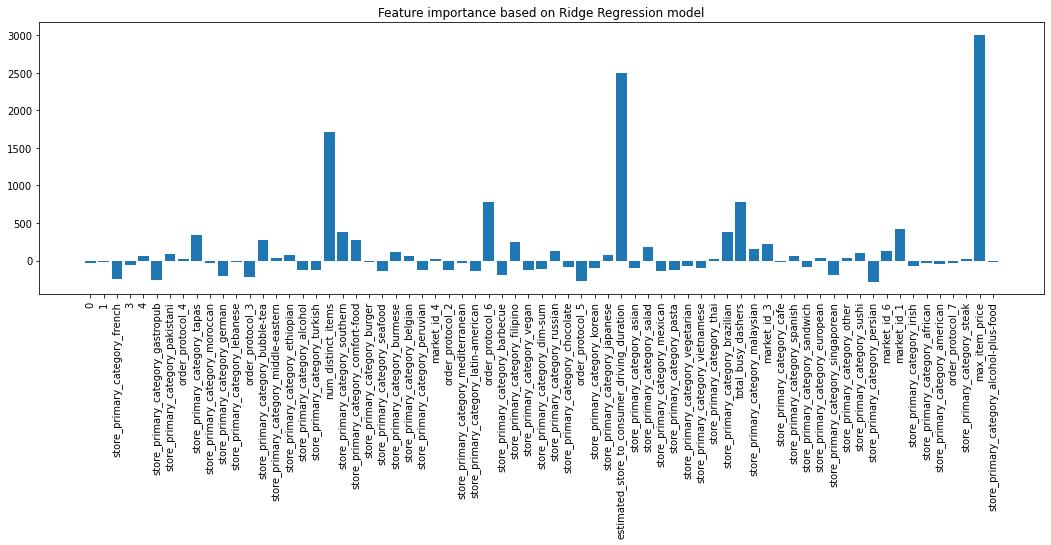

In [196]:
# Plot the coefficients generated from the fit model to observe feature importance


import matplotlib.pyplot as plt

importance = grid_ridge.best_estimator_.named_steps['Ridge'].coef_

# plot feature importance
f, ax = plt.subplots(figsize=(18,5)) 
plt.title('Feature importance based on Ridge Regression model')
plt.bar([x for x in range(len(importance))], importance)

plt.xticks([x for x in range(len(importance))], all_imp_valid_features_df.columns)
plt.xticks(rotation=90)
plt.show()



In [197]:
# Lasso Regression

lasso_pipeline = Pipeline([
    ("preprocess", preprocess),
    ('Lasso', Lasso())
])


lasso_parameters = {'Lasso__alpha':[0.1, 3 ,10]}

grid_lasso = GridSearchCV(lasso_pipeline,
                          param_grid=lasso_parameters,
                          cv = kfolds,
                          verbose=1,
                          scoring='neg_mean_absolute_error',
                          refit=True)
# ['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error']


grid_lasso.fit(X, y)
print(f'best_score: {grid_lasso.best_score_}, \n best_params: {grid_lasso.best_params_}')
grid_lasso.score(X_test, y_test)

lasso_pred = grid_lasso.predict(X_test)

print('RMSE: ',np.sqrt(mean_squared_error(y_test, lasso_pred)))
print('MAE: ',mean_absolute_error(y_test, lasso_pred))
print('R2 score: ',r2_score(y_test, lasso_pred))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    7.0s finished


best_score: -753.6942533925143, 
 best_params: {'Lasso__alpha': 0.1}
RMSE:  1011.4656585290801
MAE:  739.7007897287596
R2 score:  0.1825853727249651


In [198]:
# ElastiNet Regression

elastinet_pipeline = Pipeline([
    ("preprocess", preprocess),
    ('ElasticNet', ElasticNet())
])


elastinet_parameters = {'ElasticNet__alpha':[0.2,1,10]}
scoring = {'R2': 'r2', 'MAE': 'neg_mean_squared_error'}

grid_ElasticNet = GridSearchCV(elastinet_pipeline,
                          param_grid=elastinet_parameters,
                          cv = kfolds,
                          verbose=1,
                          scoring='r2',
                          refit=True)


grid_ElasticNet.fit(X, y)
print(f'best_score: {grid_ElasticNet.best_score_}, \n best_params: {grid_ElasticNet.best_params_}')
grid_ElasticNet.score(X_test, y_test)

elasticNet_pred = grid_ElasticNet.predict(X_test)

print('RMSE: ',np.sqrt(mean_squared_error(y_test, elasticNet_pred)))
print('MAE: ',mean_absolute_error(y_test, elasticNet_pred))
print('R2 score: ',r2_score(y_test, elasticNet_pred))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    5.8s finished


best_score: 0.03806734770267088, 
 best_params: {'ElasticNet__alpha': 0.2}
RMSE:  1087.1170983879492
MAE:  814.0819044761133
R2 score:  0.05573743259393127


Avoiding GridSearchCV due to time constriants

In [68]:
# # gridSearchCV to selected best SVR kernel and its parameters

# svr_pipe = Pipeline([
#         ('preprocess', preprocess),
#         ('svr', SVR())])

# svr_parameters = {'svr__kernel':('linear', 'rbf', 'poly'), 'svr__C':[0.01, 0.1, 1,10]}

# grid_svr = GridSearchCV(svr_pipe,
#                         param_grid=svr_parameters,
#                         cv = kfolds,
#                         verbose=1,
#                         scoring='r2',
#                         refit=True)

# # neg_mean_squared_error
# grid_svr.fit(X, y)
# print(f'best_score: {grid_svr.best_score_}, \n best_params: {grid_svr.best_params_}')
# grid_svr.score(X_test, y_test)

# svr_pred = grid_svr.predict(X_test)

# print('RMSE: ',np.sqrt(mean_squared_error(y_test, svr_pred)))
# print('MAE: ',mean_absolute_error(y_test, svr_pred))
# print('R2 score: ',r2_score(y_test, svr_pred))

In [58]:

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 50, stop = 100, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]

# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# # Use the random grid to search for best hyperparameters

# rf = RandomForestRegressor()

# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 10, verbose=2, random_state=42, n_jobs = -1,scoring='neg_mean_squared_error')

# rf_random.fit(X, y)

# print(f'best_score: {rf_random.best_score_}, \n best_params: {rf_random.best_params_}')
# rf_random.score(X_test, y_test)

In [ ]:

svr_rbf = SVR(kernel='rbf', C=1)
svr_rbf_pipeline = Pipeline([
    ("preprocess", preprocess),
    ('SVR_linear', svr_rbf)
])

svr_rbf_scores = cross_validate(svr_rbf_pipeline, X, y, cv=10,
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))

print(svr_rbf_scores['test_r2'].mean(),svr_rbf_scores['test_neg_mean_squared_error'].mean(),svr_rbf_scores['test_neg_mean_absolute_error'].mean())



In [377]:
svr_linear = SVR(kernel='linear', C=1)
svr_linear_pipeline = Pipeline([
    ("preprocess", preprocess),
    ('SVR_linear', svr_linear)
])
svr_linear_scores = cross_validate(svr_linear_pipeline, X, y, cv=10,
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))

print(svr_linear_scores['test_r2'].mean(),svr_linear_scores['test_neg_mean_squared_error'].mean(),svr_linear_scores['test_neg_mean_absolute_error'].mean())


In [378]:
svr_ply = SVR(kernel='poly', C=1)
svr_ply_pipeline = Pipeline([
    ("preprocess", preprocess),
    ('SVR_linear', svr_ply)
])
svr_ply_scores = cross_validate(svr_ply_pipeline, X, y, cv=10,
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))
print(svr_ply_scores['test_r2'].mean(),svr_ply_scores['test_neg_mean_squared_error'].mean(),svr_ply_scores['test_neg_mean_absolute_error'].mean())

In [379]:

rfr = RandomForestRegressor()
rfr_pipeline = Pipeline([
    ("preprocess", preprocess),
    ('rfr', rfr)
])
rfr_scores = cross_validate(rfr_pipeline, X, y, cv=10,
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))
print(rfr_scores['test_r2'].mean(),rfr_scores['test_neg_mean_squared_error'].mean(),rfr_scores['test_neg_mean_absolute_error'].mean())
# scores

0.06906459729160519 -1261234.1227739449 -784.7874616482777


In [59]:

#  # Trial with SGDRegressor

# n_iter=1000


# # Creating our full pipeline
# SGDR_pipeline = Pipeline([
#     ("preprocess", preprocess),
#     ('sgdR', SGDRegressor(max_iter=n_iter))
# ])

# X_train, X_val, y_train, y_val = train_test_split(X, y,  
#     test_size=0.2)
# sgd_cv= cross_val_score(SGDR_pipeline, X_train, y_train, cv=10,scoring='r2')
# print(sgd_cv, sgd_cv.mean().round(2))


In [60]:
# Multi layer perceptron 

# Scale input
mlp_scaler = StandardScaler()
mlp_scaler.fit(X)
x = mlp_scaler.transform(X)

nn = MLPRegressor(
    hidden_layer_sizes=(30,X.shape[1]),  activation='relu', solver='adam', alpha=0.001, batch_size='auto',
    learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
    random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

n = nn.fit(x, y)

# mlp_pipeline = Pipeline([
#     ("preprocess", preprocess),
#     ('nn', nn)
# ])
# scores = cross_validate(mlp_pipeline, X, y, cv=10,
#                          scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))
# print(scores['test_r2'].mean(),scores['test_neg_mean_squared_error'].mean(),scores['test_neg_mean_absolute_error'].mean())
# # scores

mlp_pred = nn.predict(mlp_scaler.transform(X_test))
print(mlp_pred)
print(y_test)

print(n.score(X_test, y_test))

print('MAE: ',mean_absolute_error(y_test, mlp_pred))
print('RMSE: ',np.sqrt(mean_squared_error(y_test, mlp_pred)))
print('R2 score: ',r2_score(y_test, mlp_pred))

[2666.84623638 2398.57650244 2896.7041889  3061.83419078 2953.2097486
 3902.44265144 3020.66588412 3081.47059278 3183.48922569 3102.78251211
 3292.50021898 3285.30592933 4078.22041024 2913.2231108  3432.82813589
 2864.5478232  2656.13103695 3046.00168588 3165.49442405 3642.14678181
 2229.94228236 3405.74887803 3343.40315159 2760.64200289 2479.34135016
 2386.72696746 2716.88365723 2558.24382207 2542.77975093 2422.35522816
 2623.20641832 2360.44977157 2785.03035437 2300.20857637 2197.92989553
 2493.34548061 3814.73511899 2573.44725946 2922.68864643 2097.22882322
 2211.85898798 2212.96680796 2573.4666555  3001.67676758 2604.42249935
 2401.46292545 2675.69859538 2495.34392385 2200.61501775 3427.4415627
 2702.56451554 3240.55127286 2623.35987554 3365.68489622 2195.16991672
 2175.3558774  2323.78698667 3475.66794444 2885.37142136 2638.99856728
 2589.98270584 2820.91527261 2741.28540547 2573.08578227 3567.61790947
 2402.70544807 2999.09643643 2781.96725833 3188.72414406 3211.46422823
 2630.36

In [61]:
# Make predictions on unseen data

valid_pred = nn.predict(mlp_scaler.transform(X_valid))
print(valid_pred)

valid_pred.shape

[3196.2042892  3039.95990441 4802.11652816 ... 2977.08584409 3084.89213783
 2615.8621951 ]


(54778,)

In [62]:
predictions = pd.DataFrame(delivery_id)
predictions['delivery_duration'] = valid_pred
predictions

,delivery_id,delivery_duration
0,194096,3196.204289
1,236895,3039.959904
2,190868,4802.116528
3,183076,2877.288382
4,186200,3320.622504
...,...,...
54773,174203,3384.586949
54774,138333,2968.405400
54775,34110,2977.085844
54776,178028,3084.892138


In [ ]:
predictions.to_csv('mlp_prediction.csv')
